In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
from tqdm import tqdm
from scipy.special import jn_zeros
from scipy.optimize import curve_fit
### Define constants, explanation in writeup previously sent
hbar = 1.05457182e-34
k_b = 1.380649e-23 #m^2 kg/s^2/K
v_f = 1e6
dos_slope = 1/pi/hbar**2/v_f**2
m_e = 9.1093837e-31
R = 100e-10
pairs = []

N_max = 10000
J_max = 225
spin_degeneracy = 1
graph_degeneracy = 4
numeric_only = True

### generate pairs to look at energy for
N_max = min(N_max, (J_max-1)**2)
print("Generating pairs")

for i in tqdm(range(1,J_max)):
    for j in range(i+1):
        for b in range(graph_degeneracy):
            for _ in range(spin_degeneracy): # degeneracy
                if i != j:
                    pairs.append((i,j))
                pairs.append((i,j))
pairs.append((0,0))
print("Evaluating pairs")
vals = [p[0]**2 + p[1]**2 for p in tqdm(pairs)]

# sort by energy

ordered = list(zip(vals, pairs))
ordered.sort()
ordered = np.array(ordered[:N_max]) # take the first 6000 energy levels

if not numeric_only:
    print("Building bessel function lookup table")
    js = [jn_zeros(i, J_max) for i in tqdm(range(J_max))] + [jn_zeros(-i, J_max) for i in tqdm(range(J_max))]


### We now have pairs corresponding to the lowest energy states (nx, ny)

Generating pairs


100%|██████████| 224/224 [00:00<00:00, 1759.30it/s]


Evaluating pairs


100%|██████████| 202497/202497 [00:00<00:00, 721119.63it/s]
C:\Users\sfska\AppData\Local\Temp\ipykernel_17776\3985024487.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ordered = np.array(ordered[:N_max]) # take the first 6000 energy levels


100%|██████████| 10000/10000 [00:00<00:00, 784392.58it/s]


Fitted C,  [0.12910287]
Compute C 0.1168237427134649 0.9048888098341126


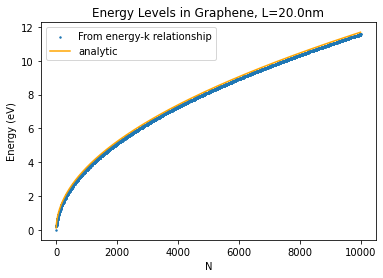

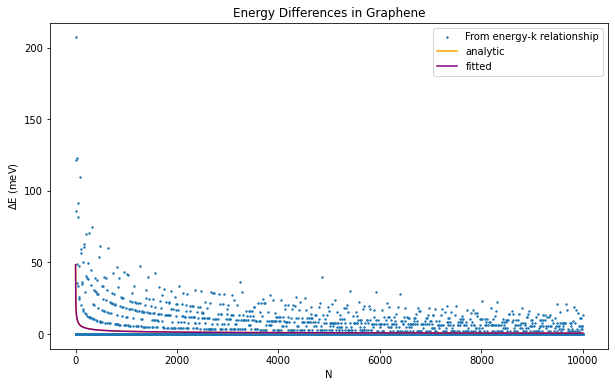

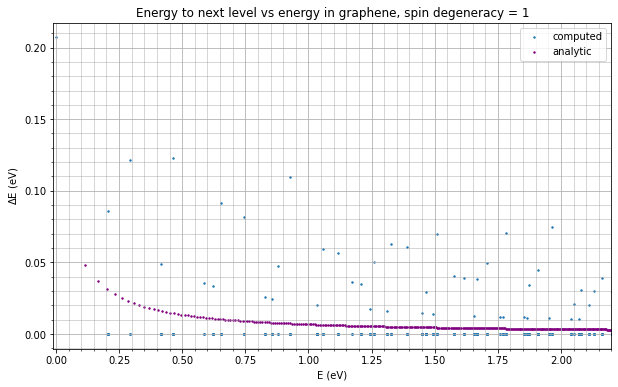

Expected energy scale 1.8827085719138095 meV
3.3130350823948174e-20


In [6]:
%matplotlib inline


### Functions for fitting
def E_dE_func(x, a, b):
    return a*np.power(x,b)

def E_dE_regression(energies, energy_diffs):
    coeffs, cov = curve_fit(E_dE_func, energies, energy_diffs
                            ,bounds = ((0,-np.inf),(np.inf,0))
                            ,p0 = [.1,-1]
    )
    a,b = coeffs
    fitted = lambda x, a=a, b=b: E_dE_func(x, a, b)
    return fitted, coeffs

def N_dE_func(x, a):
    return a*(np.sqrt(x+np.ones(len(x)))-np.sqrt(x))

def N_dE_regression(Ns, energy_diffs):
    coeffs, cov = curve_fit(N_dE_func, np.array(Ns), np.array(energy_diffs)

    )
    a = coeffs
    fitted = lambda x, a=a: N_dE_func(x, a)
    return fitted, coeffs



if not numeric_only:
    print("Evaluating pairs for analytic solution")
    energies = []
    for n, l in tqdm(pairs):
        energies.append(hbar**2/2/m_e/R**2/1.6e-19 * js[l-1][n]**2)
        energies.append(hbar**2/2/m_e/R**2/1.6e-19 * js[-l][n]**2)
    energies.sort()
    energies_diffs = 1000*np.array([energies[i+1] - energies[i] for i in range(len(energies)-1)])
    plt.plot(energies_diffs[:100], label="From solving circular well", color='purple')
    plt.xlabel("N")
    plt.ylabel("$\Delta$E meV")
    plt.title("Energy differences for circular well")
    plt.show()

### Determine energies for the lowest states
eng_dos = [2*pi*hbar*v_f/(2*R)*sqrt(o)/1.6e-19 for o in tqdm(ordered[:,0])]

### determinen delta Es
eng_dos_diffs = np.array([eng_dos[i+1] - eng_dos[i] for i in range(len(eng_dos)-1)])
Ns = [i+1 for i in range(len(eng_dos_diffs))]

# Predict deltaE from N
n_dE_fit, coeffs = N_dE_regression(Ns, eng_dos_diffs)
print("Fitted C, ", coeffs)


### analytic solution
A = 4*(R)**2
c= 2*hbar/1.6e-19*v_f*sqrt(pi/A)
print("Compute C", c, c/coeffs[0])
n_dE_fit = lambda x, a=c: N_dE_func(x, a)

## create denser domain for analytic plotting
Ns = np.linspace(Ns[0],Ns[-1], 10000)
fitted_dE = n_dE_fit(Ns)

### plot manual computed
plt.scatter([i+1 for i in range(len(eng_dos))], eng_dos, label = "From energy-k relationship", s=2)

# plot results from analytic solution
plt.plot(c*np.sqrt(Ns),label="analytic", color="orange")

plt.title("Energy Levels in Graphene, L={}nm".format(2*R*1e9))
plt.xlabel("N")
plt.ylabel("Energy (eV)")
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,6))
plt.scatter([i+1 for i in range(len(eng_dos_diffs))], 1000*eng_dos_diffs, label = "From energy-k relationship", s=2)
plt.plot(1000*c*(np.sqrt(Ns + np.ones(len(Ns)))-np.sqrt(Ns)),label="analytic", color="orange")
plt.plot(1000*fitted_dE,label="fitted", color="purple")


### plotting for N vs delta E
plt.title("Energy Differences in Graphene")
plt.xlabel("N")
plt.ylabel("$\Delta$E (meV)")
plt.legend()
# plt.savefig("graphs/graphene energy level diffs")
plt.show()

fig = plt.figure(figsize=(10,6))
plt.title("Energy to next level vs energy in graphene, spin degeneracy = {}".format(spin_degeneracy))
plt.xlabel("E (eV)")
plt.ylabel("$\Delta$E (eV)")


plt.scatter(eng_dos[:-1],eng_dos_diffs, label="computed", s=2)



domain = np.linspace(eng_dos[0], eng_dos[-2], 5000)

plt.scatter(c*np.sqrt(Ns), fitted_dE, color="purple",
         label = "analytic", s=2)

plt.xlim(-1e-2,2.2)
plt.grid()
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.5)
plt.legend()
# plt.savefig("graphs/E vs delta E")
plt.show()
